In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
data_dir = 'storage/'
dataframes = {}

for filename in os.listdir(data_dir):
    if filename.endswith(".csv"):
        print(f"Processing file: {filename}")
        asset_name = os.path.splitext(filename)[0]  # Remove .csv to get asset name
        file_path = os.path.join(data_dir, filename)
        
        # Read CSV and parse 'Date' column
        df = pd.read_csv(file_path, parse_dates=["Date"])
        
        # Store in dictionary using asset name
        dataframes[asset_name] = df
        print(f"Loaded {len(df)} rows for asset: {asset_name}")



Processing file: CBOE_VIX_15yr_data.csv
Loaded 3774 rows for asset: CBOE_VIX_15yr_data
Processing file: Crude_Oil_15yr_data.csv
Loaded 3773 rows for asset: Crude_Oil_15yr_data
Processing file: DXY_15yr_data.csv
Loaded 3775 rows for asset: DXY_15yr_data
Processing file: EUR_USD_15yr_data.csv
Loaded 3907 rows for asset: EUR_USD_15yr_data
Processing file: FTSE100_15yr_data.csv
Loaded 3787 rows for asset: FTSE100_15yr_data
Processing file: Gold_15yr_data.csv
Loaded 3772 rows for asset: Gold_15yr_data
Processing file: Nasdaq_15yr_data.csv
Loaded 3774 rows for asset: Nasdaq_15yr_data
Processing file: Nifty_50_15yr_data.csv
Loaded 3682 rows for asset: Nifty_50_15yr_data
Processing file: Nikkei_15yr_data.csv
Loaded 3670 rows for asset: Nikkei_15yr_data
Processing file: S&P500_15yr_data.csv
Loaded 3774 rows for asset: S&P500_15yr_data
Processing file: Silver_15yr_data.csv
Loaded 3772 rows for asset: Silver_15yr_data
Processing file: USD_INR_15yr_data.csv
Loaded 3907 rows for asset: USD_INR_15yr

In [6]:
df_gold = dataframes['Gold_15yr_data']
df_silver = dataframes['Silver_15yr_data']
df_crude_oil = dataframes['Crude_Oil_15yr_data']
df_usd_inr = dataframes['USD_INR_15yr_data']
df_dxy = dataframes['DXY_15yr_data']
df_nifty = dataframes['Nifty_50_15yr_data']
df_nasdaq = dataframes['Nasdaq_15yr_data']
df_ftse100 = dataframes['FTSE100_15yr_data']
df_nikkei = dataframes['Nikkei_15yr_data']
df_sp500 = dataframes['S&P500_15yr_data']
df_eur_usd = dataframes['EUR_USD_15yr_data']
df_vix = dataframes['CBOE_VIX_15yr_data']


In [7]:
assets = {
    'Gold': df_gold,
    'Silver': df_silver,
    'Crude_Oil': df_crude_oil,
    'USD_INR': df_usd_inr,
    'DXY': df_dxy,
    'EUR_USD': df_eur_usd,
    'S&P500': df_sp500,
    'Nasdaq': df_nasdaq,
    'Nikkei': df_nikkei,
    'FTSE100': df_ftse100,
    'CBOE_VIX': df_vix,
    'Nifty50': df_nifty
}

In [8]:
def engineer_features(df, prefix, rich_features=False):

    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')


    df = df.sort_values('Date').copy()
    df[f'{prefix}_return_1d'] = df['Close'].pct_change()
    df[f'{prefix}_return_3d'] = df['Close'].pct_change(3)
    if rich_features:
        df[f'{prefix}_vol_5d'] = df['Close'].pct_change().rolling(5).std()
        df[f'{prefix}_intraday_range'] = (df['High'] - df['Low']) / df['Open']
        df[f'{prefix}_volume_chg'] = df['Volume'].pct_change()
    return df[['Date'] + [col for col in df.columns if col.startswith(prefix)]]

In [9]:
base_df = engineer_features(assets['Nifty50'], 'nifty', rich_features=True)
merged_df = base_df.copy()

In [10]:
for asset, df in assets.items():
    if asset == 'Nifty50':
        continue  # Skip, already the base
    rich = asset in ['Gold', 'USD_INR', 'Crude_Oil']
    feat_df = engineer_features(df, asset, rich_features=rich)
    merged_df = merged_df.merge(feat_df, on='Date', how='left')


In [11]:
merged_df.fillna(method='ffill', inplace=True)  # Forward fill

In [12]:
nifty_close_df = assets['Nifty50'][['Date', 'Close']].copy()
nifty_close_df['Close'] = pd.to_numeric(nifty_close_df['Close'], errors='coerce')
nifty_close_df = nifty_close_df.sort_values('Date')
nifty_close_df['target'] = (nifty_close_df['Close'].shift(-1) > nifty_close_df['Close']).astype(int)


In [13]:
merged_df = merged_df.merge(nifty_close_df[['Date', 'target']], on='Date', how='left')
merged_df = merged_df.drop('USD_INR_volume_chg', axis=1)

In [14]:
print(merged_df.isna().sum())


Date                          0
nifty_return_1d               1
nifty_return_3d               3
nifty_vol_5d                  5
nifty_intraday_range          0
nifty_volume_chg            648
Gold_return_1d                2
Gold_return_3d                4
Gold_vol_5d                   6
Gold_intraday_range           1
Gold_volume_chg               2
Silver_return_1d              2
Silver_return_3d              4
Crude_Oil_return_1d           2
Crude_Oil_return_3d           4
Crude_Oil_vol_5d              6
Crude_Oil_intraday_range      1
Crude_Oil_volume_chg          2
USD_INR_return_1d             1
USD_INR_return_3d             3
USD_INR_vol_5d                5
USD_INR_intraday_range        0
DXY_return_1d                 2
DXY_return_3d                 4
EUR_USD_return_1d             1
EUR_USD_return_3d             3
S&P500_return_1d              2
S&P500_return_3d              4
Nasdaq_return_1d              2
Nasdaq_return_3d              4
Nikkei_return_1d              1
Nikkei_r

In [15]:
merged_df.dropna(inplace=True)
pd.set_option('display.max_columns', None)
merged_df.head(10)

,Date,nifty_return_1d,nifty_return_3d,nifty_vol_5d,nifty_intraday_range,nifty_volume_chg,Gold_return_1d,Gold_return_3d,Gold_vol_5d,Gold_intraday_range,Gold_volume_chg,Silver_return_1d,Silver_return_3d,Crude_Oil_return_1d,Crude_Oil_return_3d,Crude_Oil_vol_5d,Crude_Oil_intraday_range,Crude_Oil_volume_chg,USD_INR_return_1d,USD_INR_return_3d,USD_INR_vol_5d,USD_INR_intraday_range,DXY_return_1d,DXY_return_3d,EUR_USD_return_1d,EUR_USD_return_3d,S&P500_return_1d,S&P500_return_3d,Nasdaq_return_1d,Nasdaq_return_3d,Nikkei_return_1d,Nikkei_return_3d,FTSE100_return_1d,FTSE100_return_3d,CBOE_VIX_return_1d,CBOE_VIX_return_3d,target
648,2013-01-21,0.002952,0.013404,0.006263,0.004806,inf,-0.002248,0.001901,0.004457,0.003200,-0.827160,0.003649,0.012826,0.000733,0.024443,0.008847,0.007984,-0.335059,-0.011224,-0.016022,0.005753,0.005769,0.005022,0.003384,-0.003929,0.000866,0.003403,0.009264,-0.000411,0.007693,-0.015170,0.013896,0.004322,0.012615,-0.081798,-0.080443,0
649,2013-01-22,-0.005557,0.001540,0.006655,0.010000,-0.014515,0.003676,0.006002,0.004313,0.004082,0.071429,0.007680,0.020086,0.007116,0.021222,0.008906,0.014908,0.994036,0.000558,-0.016823,0.005837,0.008964,-0.002249,0.000877,-0.000639,0.001557,0.004428,0.013534,0.002702,0.008224,-0.003518,0.009453,-0.000291,0.007632,-0.002408,-0.073770,1
650,2013-01-23,0.000959,-0.001665,0.004509,0.008038,0.062016,-0.003840,-0.002425,0.003668,0.005026,0.866667,0.008150,0.019600,-0.010495,-0.002723,0.009430,0.020360,0.345263,0.000744,-0.009936,0.005563,0.006005,0.000626,0.003390,0.000186,-0.004380,0.001507,0.009366,0.003337,0.005635,-0.020816,-0.039063,0.002978,0.007019,0.002413,-0.081798,0
651,2013-01-24,-0.005773,-0.010350,0.004721,0.009502,0.351825,-0.009963,-0.010139,0.005944,0.008151,-0.535714,-0.022031,-0.006489,0.007561,0.004081,0.009060,0.016335,-0.270349,-0.002602,-0.001303,0.005050,0.005211,0.000375,-0.001249,-0.000413,-0.000865,0.000007,0.005949,-0.007385,-0.001381,0.012766,-0.011804,0.010859,0.013574,0.018459,0.018459,1
652,2013-01-25,0.009187,0.004323,0.006277,0.010972,-0.203024,-0.007847,-0.021503,0.005300,0.003969,2.384615,-0.016249,-0.030081,-0.000730,-0.003741,0.007340,0.011777,-0.203254,0.000186,-0.001674,0.005080,0.005921,-0.002502,-0.001502,0.004572,0.004345,0.005445,0.006968,0.006175,0.002078,0.028791,0.020235,0.003129,0.017041,0.015761,0.037007,1
653,2013-01-28,0.000025,0.003386,0.006109,0.004439,-0.233740,-0.002415,-0.020103,0.005286,0.002361,0.863636,-0.013598,-0.051004,0.005841,0.012706,0.007670,0.013952,-0.095671,0.002142,-0.000279,0.001735,0.007116,0.000376,-0.001752,0.007231,0.011419,-0.001850,0.003592,0.001457,0.000200,-0.009366,0.032166,0.001575,0.015619,0.052754,0.089085,0
654,2013-01-29,-0.004099,0.005075,0.005819,0.011435,0.393457,0.005023,-0.005271,0.005790,0.000482,1777.817073,0.013103,-0.016911,0.011717,0.016884,0.008669,0.015861,0.512872,0.002138,0.004472,0.001947,0.007651,-0.002758,-0.004878,-0.001466,0.010354,0.005106,0.008710,-0.000203,0.007437,0.003918,0.023148,0.007117,0.011860,-0.019160,0.048857,1
655,2013-01-30,0.000967,-0.003111,0.005819,0.004584,-0.211929,0.011561,0.014187,0.008985,0.012753,-0.692225,0.031869,0.031174,0.003792,0.021485,0.004600,0.009453,-0.164685,-0.002783,0.001490,0.002426,0.010324,-0.003519,-0.005893,0.003373,0.009147,-0.003900,-0.000665,-0.003599,-0.002349,0.022751,0.017142,-0.002540,0.006142,0.075883,0.110939,0
656,2013-01-31,-0.003468,-0.006593,0.005310,0.005442,0.356683,-0.011489,0.004962,0.009394,0.013489,-0.865369,-0.025411,0.018826,-0.004595,0.010888,0.006246,0.012250,0.091600,-0.008464,-0.009109,0.004455,0.005628,-0.000883,-0.007145,0.005685,0.007598,-0.002563,-0.001380,-0.000057,-0.003858,0.002223,0.029041,-0.007307,-0.002780,-0.002793,0.052321,0
657,2013-02-01,-0.005941,-0.008430,0.002904,0.011546,-0.054599,0.005299,0.005239,0.008833,0.012801,-0.462277,0.019371,0.025129,0.002872,0.002050,0.005876,0.016834,0.171899,-0.001688,-0.012892,0.004371,0.006671,-0.001010,-0.005405,0.003144,0.012250,0.010053,0.003535,0.011766,0.008067,0.

In [16]:
final_df = merged_df.copy()
features = [col for col in final_df.columns if col not in ['Date', 'target']]
X = final_df[features].values
y = final_df['target'].values

In [18]:
print(np.isinf(X).sum())
X_clean = np.where(np.isinf(X), np.nan, X)
print(np.isnan(X_clean).sum())

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')  # or strategy='mean'
X_imputed = imputer.fit_transform(X_clean)

55
55


In [19]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)


In [20]:
# 2️⃣ Prepare base models
base_models = [
    ('lr', LogisticRegression(solver='lbfgs', max_iter=1000)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=100, random_state=42))
]


In [21]:
# 3️⃣ Stacking - Generate Meta-Features using StratifiedKFold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
meta_features = np.zeros((X.shape[0], len(base_models)))

for idx, (name, model) in enumerate(base_models):
    print(f"Training base model: {name}")
    oof_pred = np.zeros(X.shape[0])
    for train_idx, valid_idx in skf.split(X_scaled, y):
        model.fit(X_scaled[train_idx], y[train_idx])
        oof_pred[valid_idx] = model.predict_proba(X_scaled[valid_idx])[:, 1]
    meta_features[:, idx] = oof_pred

Training base model: lr
Training base model: rf
Training base model: gb
Training base model: xgb


e:\tech-garage\Deep-learning\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:56:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
e:\tech-garage\Deep-learning\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:56:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
e:\tech-garage\Deep-learning\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [22:56:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [22]:
# 4️⃣ Train-Test Split for Meta-Model (Optional)
from sklearn.model_selection import train_test_split
meta_X_train, meta_X_test, y_train, y_test = train_test_split(meta_features, y, test_size=0.2, random_state=42)

# 5️⃣ Neural Network as Meta-Model
model = Sequential([
    Dense(64, activation='relu', input_shape=(meta_X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', 'AUC'])
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(meta_X_train, y_train, validation_data=(meta_X_test, y_test),
                    epochs=100, batch_size=32, callbacks=[early_stop], verbose=1)


Epoch 1/100
76/76 [==============================] - 2s 8ms/step - loss: 0.7435 - accuracy: 0.5336 - auc: 0.5477 - val_loss: 0.6904 - val_accuracy: 0.5222 - val_auc: 0.5886
Epoch 2/100
76/76 [==============================] - 0s 4ms/step - loss: 0.7132 - accuracy: 0.5579 - auc: 0.5548 - val_loss: 0.6882 - val_accuracy: 0.5222 - val_auc: 0.6083
Epoch 3/100
76/76 [==============================] - 0s 6ms/step - loss: 0.6940 - accuracy: 0.5773 - auc: 0.5898 - val_loss: 0.6854 - val_accuracy: 0.5222 - val_auc: 0.6204
Epoch 4/100
76/76 [==============================] - 0s 4ms/step - loss: 0.6871 - accuracy: 0.5711 - auc: 0.5878 - val_loss: 0.6826 - val_accuracy: 0.5371 - val_auc: 0.6235
Epoch 5/100
76/76 [==============================] - 0s 5ms/step - loss: 0.6779 - accuracy: 0.5863 - auc: 0.6056 - val_loss: 0.6772 - val_accuracy: 0.5815 - val_auc: 0.6261
Epoch 6/100
76/76 [==============================] - 0s 5ms/step - loss: 0.6780 - accuracy: 0.5715 - auc: 0.5981 - val_loss: 0.6718 - v

In [23]:
# 6️⃣ Evaluation
y_pred_prob = model.predict(meta_X_test).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)
print("\nMetrics on Test Set:")
print(f"Log Loss: {log_loss(y_test, y_pred_prob):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


19/19 [==============================] - 0s 1ms/step

Metrics on Test Set:
Log Loss: 0.6563
Accuracy: 0.6145
ROC AUC: 0.6570
Precision: 0.5981
Recall: 0.7981
F1 Score: 0.6838

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.41      0.51       290
           1       0.60      0.80      0.68       317

    accuracy                           0.61       607
   macro avg       0.63      0.61      0.60       607
weighted avg       0.62      0.61      0.60       607



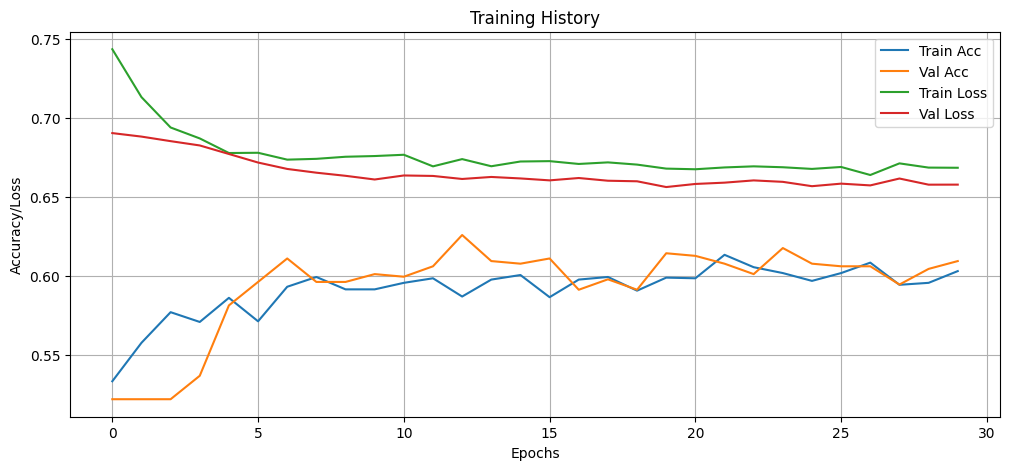

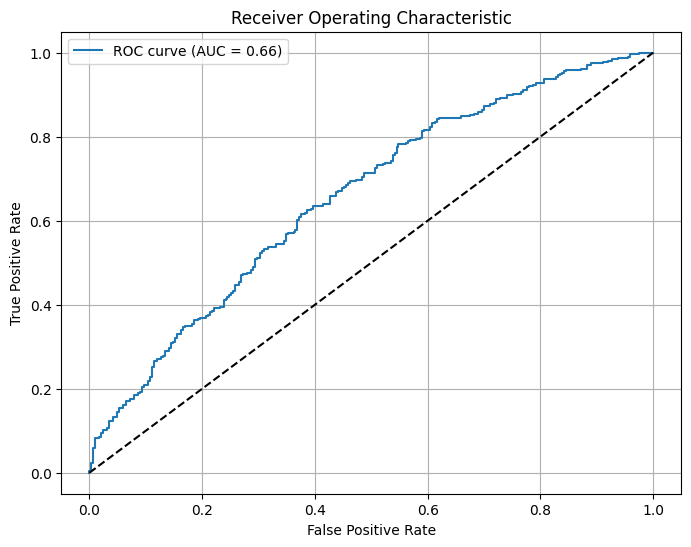

In [24]:
# 7️⃣ Visualizations
# Training history
plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Accuracy/Loss')
plt.legend()
plt.grid()
plt.show()

# ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()
